In [1]:
from orphics import sehgal, maps
import healpy as hp
from pixell import utils, enmap, curvedsky, enplot, wcsutils
import os
import numpy as np

import matplotlib.pyplot as plt
import lmdb
from cosmikyu import datasets, transforms, gan, config
from cosmikyu import nn as cnn

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')


#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/201020_logzshrink_normalization_info_validation.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/281220_logz_normalization_info_validation.npz"
compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
STanh = cnn.ScaledTanh(15., 2./15.)
LF = cnn.LinearFeature(4,4)
SDN = transforms.SehgalDataNormalizerScaledLogZShrink(norm_info_file, channel_idxes=["kappa"])
SDUN = transforms.SehgalDataUnnormalizerScaledLogZShrink(norm_info_file)

experiment_id = "6dd3053687de464aabc4a2bb441e60cf"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/{}/model".format(experiment_id)
print(model_dir)
save_point = 6
shape=(5,128,128)
cuda = True
gen_act = [LF, STanh]
dropout_rate = 0

#GK = datasets.SehgalDataSet(sehgal_dir,"Gkappa191120", transforms=[SDN], dummy_label=False,
#                            dtype=np.float64, shape=(1,128,128))
GK = datasets.SehgalDataSet(sehgal_dir,"Gkappa281220", transforms=[SDN], dummy_label=False,
                            dtype=np.float64, shape=(1,128,128))
PIXGAN = gan.PIXGAN_WGP("sehgal_pixgan_281220", shape, nconv_fcgen=64,
                          nconv_fcdis=64, cuda=cuda, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=5, kernal_size=4, stride=2,
                          padding=1, output_padding=0, gen_act=gen_act, nin_channel=1, nout_channel=4, nthresh_layer_gen=3, nthresh_layer_disc=0,
                        dropout_rate=0)
PIXGAN.load_states(model_dir, "_{}".format(save_point))


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.M

/home/dwhan89/workspace/cosmikyu/output/sehgal_pixganwgp_281220/6dd3053687de464aabc4a2bb441e60cf/model
loading saved states _6


In [16]:
ntrain = 200*1000
nbatch = 512
overwrite = True

stamp_byte = np.zeros((5, 128, 128), dtype=np.float32).nbytes
output_dir = "/home/dwhan89/workspace/cosmikyu/data/sehgal"
def output_path(x):
    return os.path.join(output_dir, x)
    
#train_db = output_path("sehgal_train_tertiary191120")
train_db = output_path("sehgal_train_tertiary281220_fromcat")
if not os.path.exists(train_db) or overwrite:
    map_size = stamp_byte*ntrain*10
    DB = lmdb.open(train_db, map_size=map_size)
    nitr = int(np.ceil(ntrain/nbatch))
    ctr = 0
    while(ctr < ntrain):
        cbatch = ntrain - ctr if ctr + nbatch > ntrain else nbatch
        print(ctr, cbatch)
        kmap = np.zeros((cbatch,1,128,128))
        for i in range(ctr, ctr+cbatch):
            kmap[i-ctr,0,...] = GK[i].copy()
        #print(np.max(kmap))
        temp = PIXGAN.generate_samples(kmap, concat=True, train=False).to(device="cpu").data.numpy()
        del kmap
        #print(np.max(SDUN(temp[0].copy())))
        
        with DB.begin(write=True) as txn:
            for i in range(ctr, ctr+cbatch):
                str_idx = '{:08}'.format(i)
                txn.put(str_idx.encode('ascii'), SDUN(temp[i-ctr].copy()).tobytes())

        ctr += cbatch
        del temp
        

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 512
512 512
1024 512
1536 512
2048 512
2560 512
3072 512
3584 512
4096 512
4608 512
5120 512
5632 512
6144 512
6656 512
7168 512
7680 512
8192 512
8704 512
9216 512
9728 512
10240 512
10752 512
11264 512
11776 512
12288 512
12800 512
13312 512
13824 512
14336 512
14848 512
15360 512
15872 512
16384 512
16896 512
17408 512
17920 512
18432 512
18944 512
19456 512
19968 512
20480 512
20992 512
21504 512
22016 512
22528 512
23040 512
23552 512
24064 512
24576 512
25088 512
25600 512
26112 512
26624 512
27136 512
27648 512
28160 512
28672 512
29184 512
29696 512
30208 512
30720 512
31232 512
31744 512
32256 512
32768 512
33280 512
33792 512
34304 512
34816 512
35328 512
35840 512
36352 512
36864 512
37376 512
37888 512
38400 512
38912 512
39424 512
39936 512
40448 512
40960 512
41472 512
41984 512
42496 512
43008 512
43520 512
44032 512
44544 512
45056 512
45568 512
46080 512
46592 512
47104 512
47616 512
48128 512
48640 512
49152 512
49664 512
50176 512
50688 512
51200 512
51712 512
5222

In [17]:
SDS_train = datasets.SehgalDataSet(output_dir, "train_tertiary281220_fromcat", dtype=np.float32)
DSJ = datasets.DataSetJoiner([SDS_train,SDS_train],  dtype=np.float64, shape=(10, 128, 128))


Number of joined samples are 200000


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


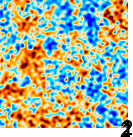

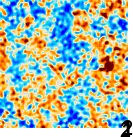

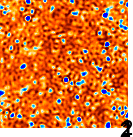

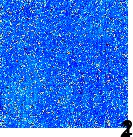

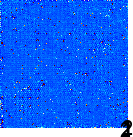

In [21]:
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(5):
    enplot.pshow(enmap.enmap(SDS_train[10][j].copy()))

In [ ]:
SDS_train = datasets.SehgalDataSet(output_dir, "train_tertiary081120", dtype=np.float32)
nplot = 1
_, wcs = maps.rect_geometry(width_arcmin=64., px_res_arcmin=0.5)
for j in range(5):
    print(np.max((SDS_train[1].copy())[j]))
    enplot.pshow(enmap.enmap(SDN(SDS_train[0]).copy()[j], wcs))